In [2]:
N = 3000  # number_of_columns_to_selected_in_termDocumentMatrix
target = 'threat'

In [3]:
import textmining
import nltk
import string
import numpy as np
from textblob import TextBlob
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBClassifier
from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.feature_selection import SelectFromModel

In [4]:
data = pd.read_csv("./Dataset/train.csv")
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
sum(data.id.isna())

0

In [6]:
data = data.loc[:, 'id':'identity_hate']
d1 = data.loc[data[target] == 1]
d2 = data.loc[data[target] == 0]
d1.shape
d2.shape[0]
d3 = d1.append(d2[0:d1.shape[0]])
d3.shape
d3.groupby(target).size()
d3 = d3.sort_index()

data = d3.copy()
del([d1,d2,d3])

In [7]:
data.index = range(0, data.shape[0])

In [8]:
id_column = data[['id']]
id_column.shape

(956, 1)

In [9]:
data.groupby(target).size()

threat
0    478
1    478
dtype: int64

# Pre-processing

In [10]:
stopwd = set(stopwords.words("english"))
punctuations = set(string.punctuation)

In [11]:
def clean(doc):
    stopwd_free = " ".join([i for i in doc.lower().split() if i not in stopwd])
    punc_free = "".join(i for i in stopwd_free if i not in punctuations)
    num_free = "".join(i for i in punc_free if not i.isdigit())
    return num_free

In [12]:
data_corpus = [clean(data.iloc[i,1]) for i in range(0, data.shape[0])]

In [13]:
data['comment_text'] = data_corpus

In [14]:
vectorizer = CountVectorizer(min_df=2, max_features=N)
vec = vectorizer.fit(data['comment_text'])

In [15]:
X = vec.transform(data['comment_text'])
X.shape

(956, 2494)

In [16]:
train_tdm_all_features = vec.get_feature_names()           # <<=====
len(train_tdm_all_features)

2494

In [17]:
df_tdm = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

In [18]:
df_tdm[target] = data[target]
df_tdm[target] = np.where(df_tdm[target] == 0.0, 0, 1)

In [19]:
df_tdm['id'] = id_column
df_tdm.head()

,able,about,above,absence,absolutely,abuse,abused,ac,academic,accept,...,ŵhen,ŵhere,ŵill,ŷou,ŷour,ṃake,ṃaśţurbaţion,ṃuţilaţe,ṗroçeśś,ṗull
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Splitting into train and test data

In [20]:
training_data = df_tdm.sample(n= int(0.8*(df_tdm.shape[0])), random_state=7)
training_data.head()

,able,about,above,absence,absolutely,abuse,abused,ac,academic,accept,...,ŵhen,ŵhere,ŵill,ŷou,ŷour,ṃake,ṃaśţurbaţion,ṃuţilaţe,ṗroçeśś,ṗull
525,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
473,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
228,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
790,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
index_of_training_data = training_data.index
index_of_testing_data = [index for index in df_tdm.index if index not in index_of_training_data]
test_data = df_tdm.loc[index_of_testing_data]
test_data.head()

,able,about,above,absence,absolutely,abuse,abused,ac,academic,accept,...,ŵhen,ŵhere,ŵill,ŷou,ŷour,ṃake,ṃaśţurbaţion,ṃuţilaţe,ṗroçeśś,ṗull
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
df_tdm.groupby([target]).size()

threat
0    478
1    478
dtype: int64

In [23]:
training_data.groupby([target]).size()

threat
0    382
1    382
dtype: int64

In [24]:
test_data.groupby([target]).size()

threat
0    96
1    96
dtype: int64

# Creating Model

In [25]:
predictors = [x for x in df_tdm.columns if x not in [target, 'id']]
len(predictors)

2492

In [28]:
xgb_model01 = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=1000, silent=False, 
                            objective='binary:logistic', n_jobs=-1, gamma=0, min_child_weight=1, 
                            subsample=0.8, colsample_bytree=0.8, seed=5)

In [29]:
xgb_params = xgb_model01.get_xgb_params()
xgtrain = xgb.DMatrix(pd.DataFrame(training_data[predictors]), label=training_data[target].values)
cvresult = xgb.cv(params=xgb_params, dtrain=xgtrain, num_boost_round=xgb_model01.get_params()['n_estimators'], nfold=5, 
                  stratified=False, folds=None, metrics='auc', obj=None, feval=None, 
                  maximize=False, early_stopping_rounds=50, verbose_eval=True)
xgb_model01.set_params(n_estimators=cvresult.shape[0])   

#Fit the xgb_model01 algorithm on the data
xgb_model01.fit(X=training_data[predictors], 
        y=training_data[target], 
        eval_metric='auc')


[0]	train-auc:0.815049+0.0204411	test-auc:0.795665+0.0351697
[1]	train-auc:0.852214+0.0120504	test-auc:0.833541+0.0402651
[2]	train-auc:0.873258+0.0113385	test-auc:0.854593+0.0452564
[3]	train-auc:0.883735+0.018683	test-auc:0.867135+0.0494122
[4]	train-auc:0.895032+0.0123685	test-auc:0.86967+0.0417376
[5]	train-auc:0.899274+0.0143179	test-auc:0.875353+0.0390632
[6]	train-auc:0.907854+0.00782168	test-auc:0.881207+0.0424568
[7]	train-auc:0.913757+0.00562567	test-auc:0.889279+0.0345866
[8]	train-auc:0.916271+0.00792071	test-auc:0.890394+0.034255
[9]	train-auc:0.925302+0.00654775	test-auc:0.896667+0.0359442
[10]	train-auc:0.928765+0.00632779	test-auc:0.898829+0.0340735
[11]	train-auc:0.931886+0.00977054	test-auc:0.902114+0.0344578
[12]	train-auc:0.933967+0.00661779	test-auc:0.902295+0.0336229
[13]	train-auc:0.936027+0.00546598	test-auc:0.906909+0.0309424
[14]	train-auc:0.939091+0.00516479	test-auc:0.911308+0.0272215
[15]	train-auc:0.941641+0.00431301	test-auc:0.914614+0.0272326
[16]	train-

[131]	train-auc:0.986628+0.00163499	test-auc:0.940724+0.0226861
[132]	train-auc:0.98663+0.00163808	test-auc:0.94038+0.0229666
[133]	train-auc:0.986692+0.00173452	test-auc:0.94038+0.0228077
[134]	train-auc:0.986707+0.00172249	test-auc:0.940518+0.022635
[135]	train-auc:0.98675+0.00168861	test-auc:0.940654+0.0224311
[136]	train-auc:0.986857+0.00171979	test-auc:0.940689+0.0222963
[137]	train-auc:0.986852+0.00170186	test-auc:0.940587+0.0221115
[138]	train-auc:0.986917+0.00171992	test-auc:0.940758+0.0222217
[139]	train-auc:0.986951+0.00171177	test-auc:0.940896+0.022175
[140]	train-auc:0.987038+0.00169182	test-auc:0.940554+0.0224241
[141]	train-auc:0.987087+0.00170053	test-auc:0.940347+0.0221732
[142]	train-auc:0.987099+0.00178703	test-auc:0.940211+0.0220839
[143]	train-auc:0.987171+0.00179937	test-auc:0.940005+0.0219614
[144]	train-auc:0.987215+0.00176693	test-auc:0.93997+0.0217686
[145]	train-auc:0.987214+0.00182006	test-auc:0.940314+0.0217563
[146]	train-auc:0.987267+0.00181047	test-auc:0.

[260]	train-auc:0.989772+0.00117787	test-auc:0.941332+0.0225993
[261]	train-auc:0.989822+0.00114892	test-auc:0.9414+0.0226361
[262]	train-auc:0.989862+0.00115696	test-auc:0.941261+0.0228926
[263]	train-auc:0.989901+0.00113868	test-auc:0.941261+0.0228167
[264]	train-auc:0.989875+0.00122972	test-auc:0.9414+0.022559
[265]	train-auc:0.989865+0.00119905	test-auc:0.941433+0.0225809
[266]	train-auc:0.989884+0.00117406	test-auc:0.941468+0.0224569
[267]	train-auc:0.989974+0.00112398	test-auc:0.94126+0.0226694
[268]	train-auc:0.989985+0.00113042	test-auc:0.941397+0.0230216
[269]	train-auc:0.989978+0.00110681	test-auc:0.941363+0.0229676
[270]	train-auc:0.990017+0.00106982	test-auc:0.941089+0.022839
[271]	train-auc:0.990015+0.00110754	test-auc:0.941123+0.0229187
[272]	train-auc:0.990023+0.00111679	test-auc:0.94126+0.0228817
[273]	train-auc:0.98991+0.0012989	test-auc:0.941637+0.0228428
[274]	train-auc:0.989918+0.00130412	test-auc:0.941947+0.0226274
[275]	train-auc:0.98992+0.00131376	test-auc:0.9419

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=284,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=5, silent=False, subsample=0.8)

###### Feature Importance Graph

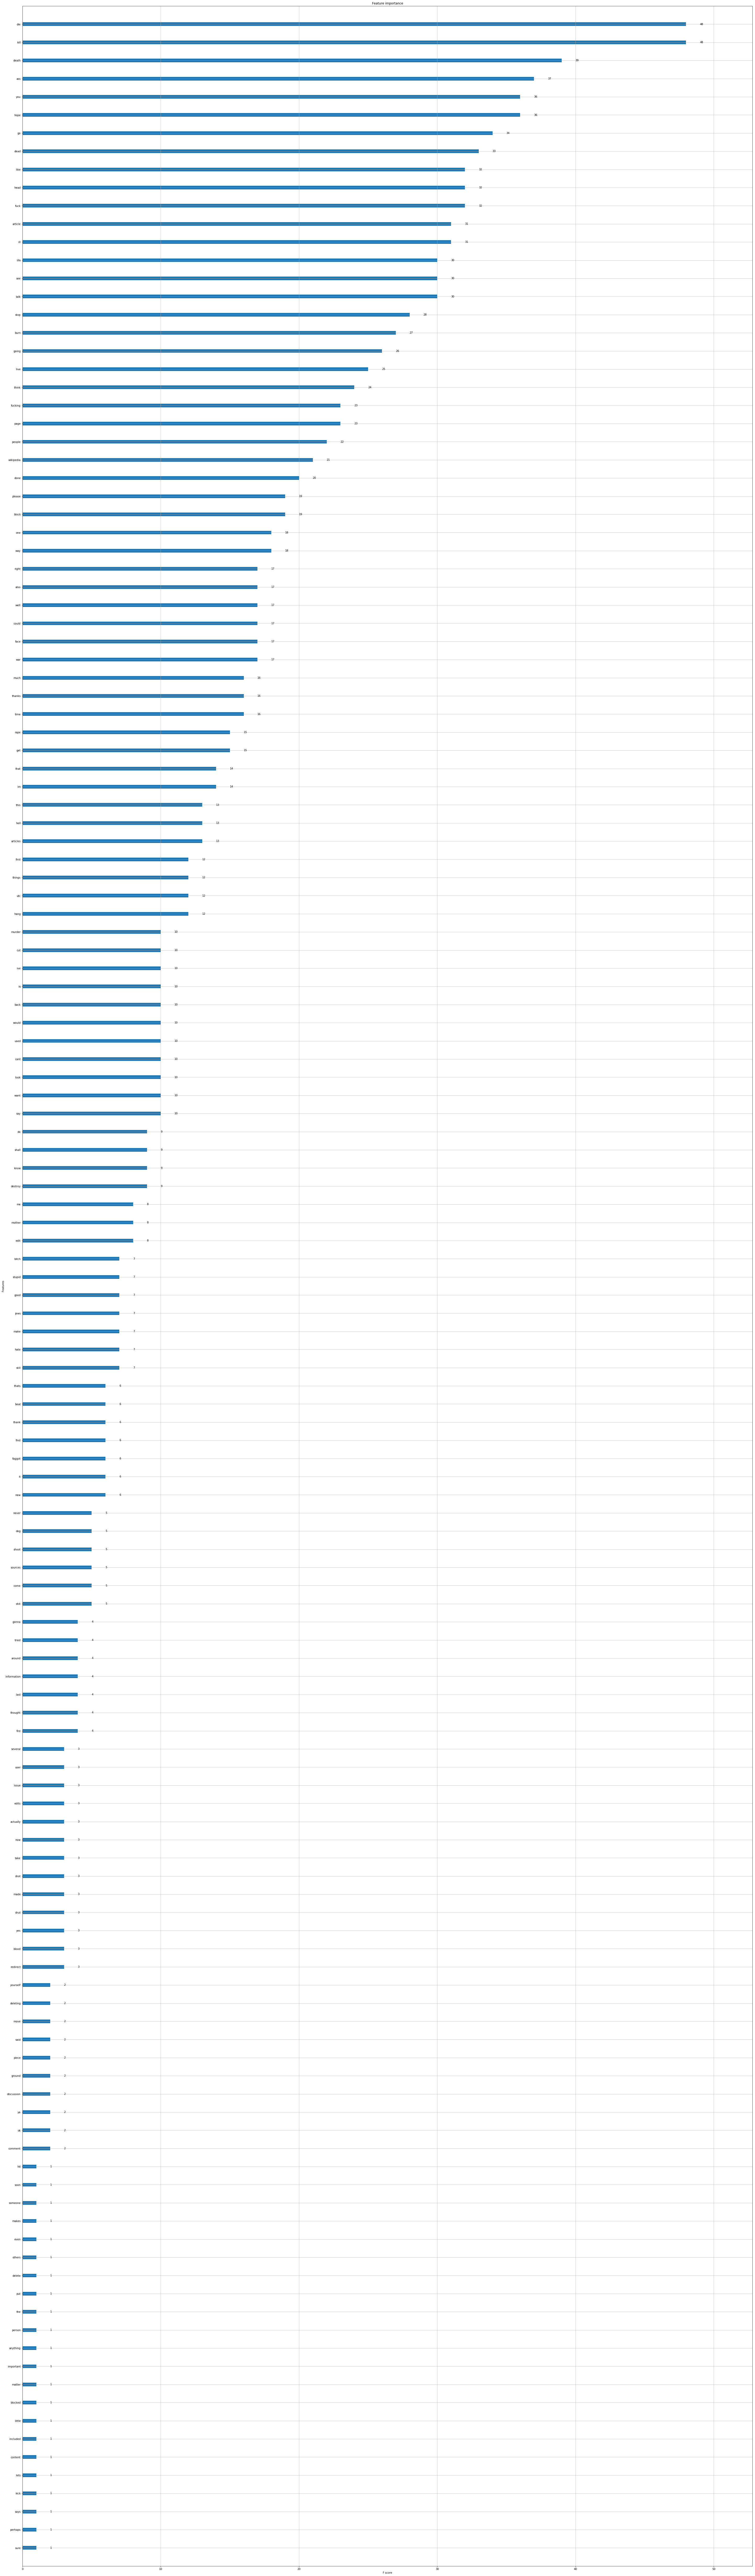

In [30]:
rcParams['figure.figsize'] = 50,180
xgb.plot_importance(xgb_model01.get_booster())

In [50]:
#Predict training set:
train_predictions = xgb_model01.predict(training_data[predictors])
train_predprob = xgb_model01.predict_proba(training_data[predictors])[:, 1]  

#Print model report:
acc = float(accuracy_score(training_data[target], train_predictions)) * 100
AUC = float(roc_auc_score(training_data[target], train_predprob, average='weighted')) * 100
f1 = float(f1_score(training_data[target], train_predictions, average='weighted')) * 100

print("\nModel Report (TRAIN) :\n")
print("Accurary : %.6g" % acc)
print("AUC Score : %.6g" % AUC)
print("F1 Score : %.6g" % f1)

# Predicting on test data:
test_predictions = xgb_model01.predict(test_data[predictors])
test_predprob = xgb_model01.predict_proba(test_data[predictors])[:, 1]  

#Print model report:
acc = float(accuracy_score(test_data[target], test_predictions)) * 100
AUC = float(roc_auc_score(test_data[target], test_predprob, average='weighted')) * 100
f1 = float(f1_score(test_data[target], test_predictions, average='weighted')) * 100

print("\nModel Report (TEST) : \n")
print("Accurary : %.6g" % acc)
print("AUC Score : %.6g" % AUC)
print("F1 Score : %.6g" % f1)


Model Report (TRAIN) :

Accurary : 94.3717
AUC Score : 99.066
F1 Score : 94.3689

Model Report (TEST) : 

Accurary : 86.4583
AUC Score : 93.5113
F1 Score : 86.4215


C:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Saving Model

In [52]:
path = './model pickle/'
filename = path + "XGBClassifier_equalData_" + target + "_" + str(N) + "_F1_Score" + str(format(f1, '.6g'))
joblib.dump(xgb_model01, filename)

['./model pickle/XGBClassifier_equalData_threat_3000_F1_Score86.4215']

# Loading Model

In [32]:
# path = './model pickle/'
# filename = path + 'XGBClassifier_equalData_toxic_3000_F1_Score87.6949'
# xgb_model01 = joblib.load(filename)

# Probability prediction for test.csv provided by kaggle

In [53]:
testCSV = pd.read_csv('./Dataset/test.csv')

In [54]:
testCSV.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [55]:
testCSV.shape

(153164, 2)

### Pre-processing

In [56]:
data_corpus_testCSV = [clean(testCSV.iloc[i,1]) for i in range(0, testCSV.shape[0])]

In [57]:
testCSV['comment_text'] = data_corpus_testCSV

In [58]:
testCSV.head()

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule succesful ever whats hating s...
1,0000247867823ef7,rfc title fine is imo
2,00013b17ad220c46,sources zawe ashton lapland —
3,00017563c3f7919a,if look back source information updated correc...
4,00017695ad8997eb,anonymously edit articles all


In [62]:
vectorizer = CountVectorizer(min_df=2, max_features=N, vocabulary=train_tdm_all_features) 
vec = vectorizer.fit(testCSV['comment_text'])

In [63]:
X = vec.transform(testCSV['comment_text'])
X.shape

(153164, 2494)

In [64]:
df_tdm_testCSV = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

In [65]:
df_tdm_testCSV.id = testCSV.id

In [66]:
predictors_for_testCSV = [x for x in df_tdm_testCSV.columns if x not in [target, 'id']]

In [67]:
df_tdm_testCSV[predictors_for_testCSV].shape

(153164, 2492)

In [69]:
df_tdm_testCSV.head()

,able,about,above,absence,absolutely,abuse,abused,ac,academic,accept,...,ŵhen,ŵhere,ŵill,ŷou,ŷour,ṃake,ṃaśţurbaţion,ṃuţilaţe,ṗroçeśś,ṗull
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
prediction_final = xgb_model01.predict_proba((df_tdm_testCSV[predictors_for_testCSV]))[:,1]

In [71]:
final_submission = pd.read_csv('./sample_submission.csv')

In [72]:
final_submission[target] = prediction_final

In [73]:
final_submission.head()

,Unnamed: 0,id,toxic,severe_toxic,obscene,threat
0,0,00001cee341fdb12,0.999996,0.945681,0.998782,0.933109
1,1,0000247867823ef7,0.166511,0.245883,0.245466,0.225509
2,2,00013b17ad220c46,0.266785,0.245883,0.213822,0.156009
3,3,00017563c3f7919a,0.071220,0.223626,0.091228,0.491236
4,4,00017695ad8997eb,0.327090,0.121694,0.182571,0.067571


In [74]:
final_submission = final_submission.drop(['Unnamed: 0'], axis=1)

In [75]:
final_submission.head()

,id,toxic,severe_toxic,obscene,threat
0,00001cee341fdb12,0.999996,0.945681,0.998782,0.933109
1,0000247867823ef7,0.166511,0.245883,0.245466,0.225509
2,00013b17ad220c46,0.266785,0.245883,0.213822,0.156009
3,00017563c3f7919a,0.071220,0.223626,0.091228,0.491236
4,00017695ad8997eb,0.327090,0.121694,0.182571,0.067571


###### Saving csv file on the disk

In [76]:
final_submission.to_csv('./sample_submission.csv')